# Exercise2.2-练习李老师课间内容
- 本节主要目的：利用MakcClass重构束流径迹，与Exercise1.4的方法不同，在其基础上有所升级，见代码；

## MakeClasss生成tracking.h和tracking.C文件
### 修改tracking.h
- 在traking.h 代码中增加了用户变量，成员函数SetBranch()，TrackInit() 以及SetTrace()定义

```c++
//////////////////////////////////////////////////////////
// This class has been automatically generated on
// Sun May 16 17:07:31 2021 by ROOT version 6.16/00
// from TTree tree/tree
// found on file: f8ppac001.root
//////////////////////////////////////////////////////////

#ifndef tracking_h
#define tracking_h

#include <TROOT.h>
#include <TChain.h>
#include <TFile.h>

// Header file for the classes stored in the TTree if any.

class tracking {
public :
   TTree          *fChain;   //!pointer to the analyzed TTree or TChain
   Int_t           fCurrent; //!current Tree number in a TChain

// Fixed size dimensions of array or collections stored in the TTree if any.

   // Declaration of leaf types
   Float_t         PPACF8[5][5];
   Float_t         F8PPACRawData[5][5];
   Int_t           beamTrig;
   Int_t           must2Trig;
   Float_t         targetX;
   Float_t         targetY;

   //Declaration by user
   Double_t xx[3],xz[3],yy[3],yz[3];//1A,2A,3
   Double_t xx2b[2],yy2b[2],xz2b,yz2b;//2B x,y, 0-measured, 1- fitted.
   Double_t anode2b;
   Double_t dx[3],dy[3];//residual
   Double_t tx,ty;//target position
   Double_t c2nx,c2ny;//chi2/ndf for xfit,yfit


   // List of branches
   TBranch        *b_PPACF8;   //!
   TBranch        *b_F8PPACRawData;   //!
   TBranch        *b_beamTrig;   //!
   TBranch        *b_must2Trig;   //!
   TBranch        *b_targetX;   //!
   TBranch        *b_targetY;   //!

   tracking(TTree *tree=0);
   virtual ~tracking();
   virtual Int_t    Cut(Long64_t entry);
   virtual Int_t    GetEntry(Long64_t entry);
   virtual Long64_t LoadTree(Long64_t entry);
   virtual void     Init(TTree *tree);
   virtual void     Loop();
   virtual Bool_t   Notify();
   virtual void     Show(Long64_t entry = -1);
   //Declaration by user
   virtual void     SetBranch(TTree * tree);
   virtual void     TrackInit();
   virtual void     SetTrace(TH2D *h, Double_t k, Double_t b, Int_t min, Int_t max);
};

#endif

#ifdef tracking_cxx
tracking::tracking(TTree *tree) : fChain(0) 
{
// if parameter tree is not specified (or zero), connect the file
// used to generate this class and read the Tree.
   if (tree == 0) {
      TFile *f = (TFile*)gROOT->GetListOfFiles()->FindObject("f8ppac001.root");
      if (!f || !f->IsOpen()) {
         f = new TFile("f8ppac001.root");
      }
      f->GetObject("tree",tree);

   }
   Init(tree);
}

tracking::~tracking()
{
   if (!fChain) return;
   delete fChain->GetCurrentFile();
}

Int_t tracking::GetEntry(Long64_t entry)
{
// Read contents of entry.
   if (!fChain) return 0;
   return fChain->GetEntry(entry);
}
Long64_t tracking::LoadTree(Long64_t entry)
{
// Set the environment to read one entry
   if (!fChain) return -5;
   Long64_t centry = fChain->LoadTree(entry);
   if (centry < 0) return centry;
   if (fChain->GetTreeNumber() != fCurrent) {
      fCurrent = fChain->GetTreeNumber();
      Notify();
   }
   return centry;
}

void tracking::Init(TTree *tree)
{
   // The Init() function is called when the selector needs to initialize
   // a new tree or chain. Typically here the branch addresses and branch
   // pointers of the tree will be set.
   // It is normally not necessary to make changes to the generated
   // code, but the routine can be extended by the user if needed.
   // Init() will be called many times when running on PROOF
   // (once per file to be processed).

   // Set branch addresses and branch pointers
   if (!tree) return;
   fChain = tree;
   fCurrent = -1;
   fChain->SetMakeClass(1);

   fChain->SetBranchAddress("PPACF8", PPACF8, &b_PPACF8);
   fChain->SetBranchAddress("F8PPACRawData", F8PPACRawData, &b_F8PPACRawData);
   fChain->SetBranchAddress("beamTrig", &beamTrig, &b_beamTrig);
   fChain->SetBranchAddress("must2Trig", &must2Trig, &b_must2Trig);
   fChain->SetBranchAddress("targetX", &targetX, &b_targetX);
   fChain->SetBranchAddress("targetY", &targetY, &b_targetY);
   Notify();
}

Bool_t tracking::Notify()
{
   // The Notify() function is called when a new file is opened. This
   // can be either for a new TTree in a TChain or when when a new TTree
   // is started when using PROOF. It is normally not necessary to make changes
   // to the generated code, but the routine can be extended by the
   // user if needed. The return value is currently not used.

   return kTRUE;
}

void tracking::Show(Long64_t entry)
{
// Print contents of entry.
// If entry is not specified, print current entry
   if (!fChain) return;
   fChain->Show(entry);
}
Int_t tracking::Cut(Long64_t entry)
{
// This function may be called from Loop.
// returns  1 if entry is accepted.
// returns -1 otherwise.
   return 1;
}
#endif // #ifdef tracking_cxx
```

### 修改tracking.C文件
- 在tracking的基础上进行了修改，注意#include 部分的添加

```c++
#define tracking_cxx
#include "tracking.h"
#include <TH2.h>
#include <TStyle.h>
#include <TCanvas.h>
#include <TF1.h>
#include <TFitResult.h>

void tracking::SetBranch(TTree *tree)
{
 //measured pos
 tree->Branch("xx",&xx,"xx[3]/D");//1A,2A,3
 tree->Branch("xz",&xz,"xz[3]/D");
 tree->Branch("yy",&yy,"yy[3]/D");
 tree->Branch("yz",&yz,"yz[3]/D");
 
 //difference between measured and calculated -for pos resolution.
 tree->Branch("dx",&dx,"dx[3]/D");
 tree->Branch("dy",&dy,"dy[3]/D");
 
 //2B x,y,anode
 tree->Branch("xx2b",&xx2b,"xx2b[2]/D");
 tree->Branch("yy2b",&yy2b,"yy2b[2]/D");
 tree->Branch("anode2b",&anode2b,"anode2b/D");  
 
 //target x-y
 tree->Branch("tx",&tx,"tx/D");
 tree->Branch("ty",&ty,"ty/D");
 
 //ch2/ndf for linear fitting.
 tree->Branch("c2nx",&c2nx,"c2nx/D");
 tree->Branch("c2ny",&c2ny,"c2ny/D");
 
 tree->Branch("beamTrig",&beamTrig,"beamTrig/I");
 tree->Branch("must2Trig",&must2Trig,"must2Trig/I");
 
 tree->Branch("targetX",&targetX,"targetX");
 tree->Branch("targetY",&targetY,"targetY");  
}

void tracking::TrackInit()
{
    tx=-999;
    ty=-999;

    //1A
    xx[0]=PPACF8[0][0];
    yy[0]=PPACF8[0][1];
    xz[0]=PPACF8[0][2];
    yz[0]=PPACF8[0][3];
   
    //2A
    xx[1]=PPACF8[2][0];
    yy[1]=PPACF8[2][1];
    xz[1]=PPACF8[2][2];
    yz[1]=PPACF8[2][3];
   
    //3
    xx[2]=PPACF8[4][0];
    yy[2]=PPACF8[4][1];
    xz[2]=PPACF8[4][2];
    yz[2]=PPACF8[4][3];
   
    //2B
    xx2b[0]=PPACF8[3][0];
    yy2b[0]=PPACF8[3][1];
    xz2b=PPACF8[3][2];
    yz2b=PPACF8[3][3];
    anode2b=PPACF8[3][4];
   
    xx2b[1]=-1000;
    yy2b[1]=-1000;
   
}

void tracking::SetTrace(TH2D *h,Double_t k,Double_t b,Int_t min,Int_t max)
{
  if(h==0) return;
  if(min>=max) return;
  
  for(int i=min;i<max;i++)
  {
    h->Fill(i,(Int_t)(i*k+b));
  }
}

void tracking::Loop()
{
   TH2D *htf8xz=new TH2D("htf8xz","xz trace by ppac",2200,-2000,200,300,-150,150);
   TH2D* htf8yz=new TH2D("htf8yz","yz trace by ppac",2200,-2000,200,300,-150,150);

  TFile *opf=new TFile("tracking.root","recreate");
  TTree *tree=new TTree("tree","ppac traking");
  SetBranch(tree);

   if (fChain == 0) return;
   Long64_t nentries = fChain->GetEntriesFast();
   Long64_t nbytes = 0, nb = 0;
   for (Long64_t jentry=0; jentry<nentries;jentry++) {
      Long64_t ientry = LoadTree(jentry);
      if (ientry < 0) break;
      nb = fChain->GetEntry(jentry);   nbytes += nb;
      TrackInit();
      bool b1a=abs(xx[0])<150 && abs(yy[0])<150;
      bool b2a=abs(xx[1])<150 && abs(yy[1])<150;
      bool b3=abs(xx[2])<150 && abs(yy[2])<150;
      if(!b1a || !b2a || !b3) continue;

      //fit x-z trajectory
      TFitResultPtr r;
      TGraph *grx=new TGraph(3,xz,xx);
      TF1 *fx=new TF1("fx","pol1",-2000,0);
      //fit option: Q: Quiet mode (minimum printing); 
      //            S: The result of the fit is returned in the TFitResultPtr .
      r=grx->Fit(fx,"SQ");
      xx2b[1]=fx->Eval(xz2b); 
      tx=fx->Eval(0);
      SetTrace(htf8xz,fx->GetParameter(1),fx->GetParameter(0),-1800,0);
      for(int i=0;i<3;i++) dx[i]=xx[i]-fx->Eval(xz[i]);
      c2nx=r->Chi2()/r->Ndf();//对于任何程序的自动拟合，原则上都要输出拟合误差进行评估
      delete grx;
      delete fx;

      //fit y-z trajectory      
      TGraph *gry=new TGraph(3,yz,yy);
      TF1 *fy=new TF1("fy","pol1",-2000,0);
      r=gry->Fit(fy,"SQ");
      yy2b[1]=fy->Eval(yz2b);
      ty=fy->Eval(0);
      SetTrace(htf8yz,fy->GetParameter(1),fy->GetParameter(0),-1800,0);
      for(int i=0;i<3;i++) dy[i]=yy[i]-fy->Eval(yz[i]);
      c2ny=r->Chi2()/r->Ndf(); 
      delete gry;
      delete fy;

      tree->Fill();
      if(jentry%10000==0) cout<<"processing "<<jentry<<endl;

   }
   htf8xz->Write();
   htf8yz->Write();
   tree->Write();
   opf->Close();
}
```

## 检查数据
### 打开新生成的tracking.root文件，得到root文件tree

In [1]:
//%jsroot on
TFile *ipf=new TFile("./method0/tracking.root");
TTree *tree=(TTree*) ipf->Get("tree");
TCanvas *c1=new TCanvas("c1","c1");

### 查看束流径迹
 -  x-z方向

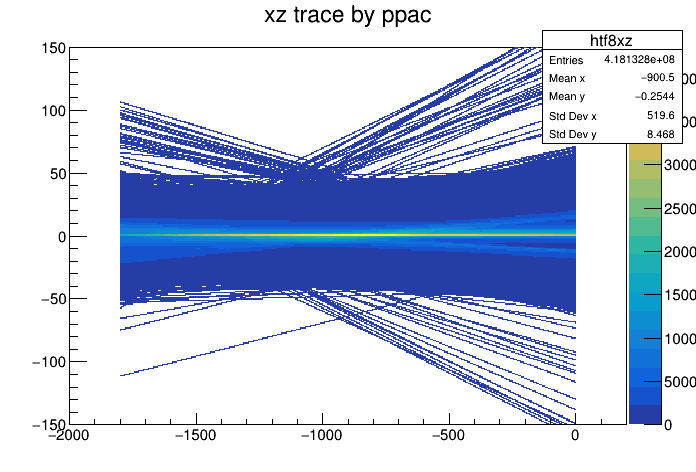

In [2]:
TH2D *hxz=(TH2D*) ipf->Get("htf8xz");
hxz->Draw("colz");
c1->Draw();

### 查看束流径迹
 -  y-z方向

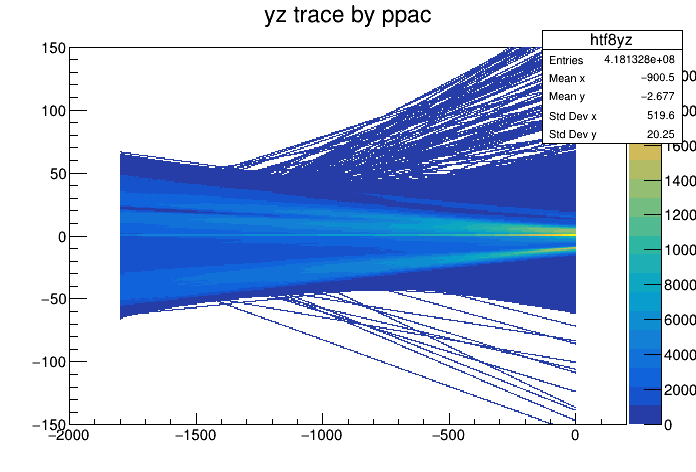

In [3]:
TH2D *hyz=(TH2D*) ipf->Get("htf8yz");
hyz->Draw("colz");
c1->Draw();

### 束流在靶上投影
- 假设靶与束流线垂直

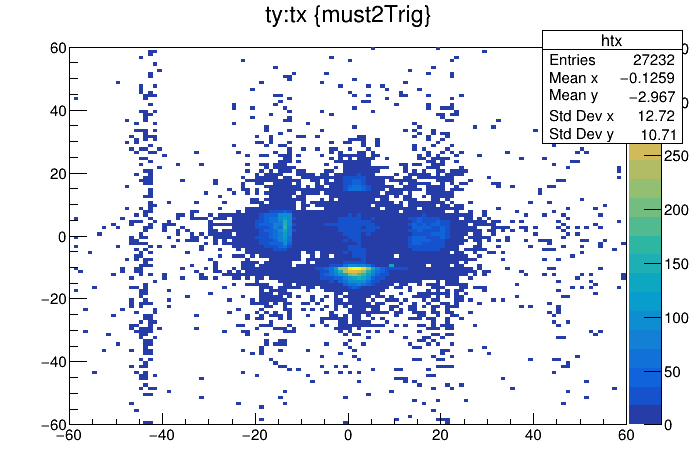

In [4]:
tree->Draw("ty:tx>>htx(120,-60,60,120,-60,60)","must2Trig","colz");
c1->Draw();

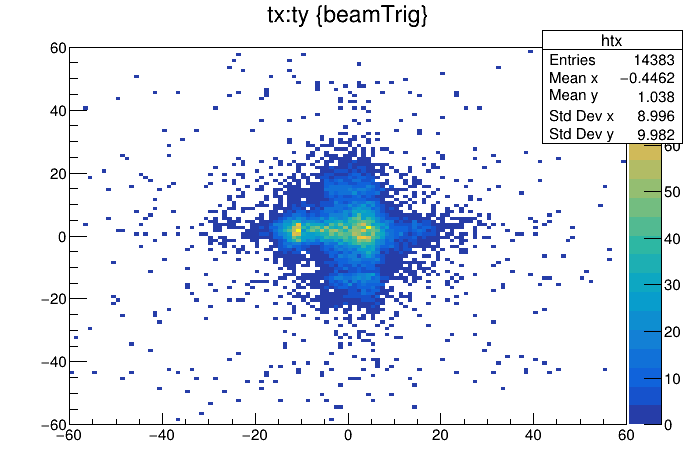

In [5]:
tree->Draw("tx:ty>>htx(120,-60,60,120,-60,60)","beamTrig","colz");
c1->Draw();

### 参差分析

In [6]:
TF1 *total2=new TF1("total2","gaus(0)+gaus(3)");

In [7]:
TF1 *g1 = new TF1("g1","gaus");
TF1 *g2 = new TF1("g2","gaus");
TF1 *total=new TF1("total","gaus(0)+gaus(3)");
TH1F *hdx;
Double_t sigma;

 FCN=1890.97 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=1.14987e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.64292e+04   5.32958e+01   8.23904e-01  -2.78910e-05
   2  Mean        -6.44376e-02   5.86192e-04   1.23601e-05   1.70567e+00
   3  Sigma        2.25004e-01   6.03074e-04   1.43684e-05  -7.82901e-01


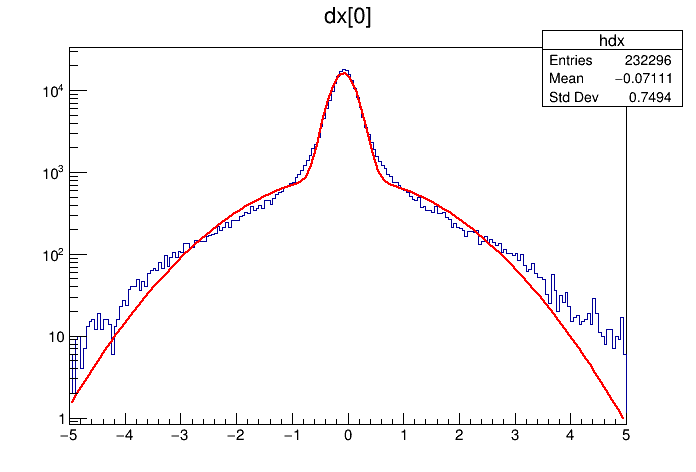

 FCN=4054.38 FROM MIGRAD    STATUS=CONVERGED     594 CALLS         595 TOTAL
                     EDM=1.55795e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.55394e+04   5.44512e+01   9.81149e-02  -1.08668e-06
   2  p1          -6.90450e-02   5.92336e-04   1.22978e-06   1.36840e-01
   3  p2           2.16951e-01   6.50859e-04  -2.45794e-06   3.01129e-01
   4  p3           8.52983e+02   8.05746e+00   8.65320e-03   5.75989e-06
   5  p4          -8.68282e-02   5.53628e-03   1.66783e-06  -7.01878e-03
   6  p5           1.36889e+00   7.15795e-03  -9.59286e-06   1.22853e-03


In [8]:
tree->Draw("dx[0]>>hdx(200,-5,5)");
hdx=(TH1F*)gROOT->FindObject("hdx");
hdx->Fit("g1","","",-0.5,0.5);
sigma=g1->GetParameter(2);
total->SetParameter(2,sigma);
total->SetParameter(5,5*sigma);//初始化，估计半宽为2*sigma；
hdx->Fit("total");
gPad->SetLogy();
c1->Draw();//residual

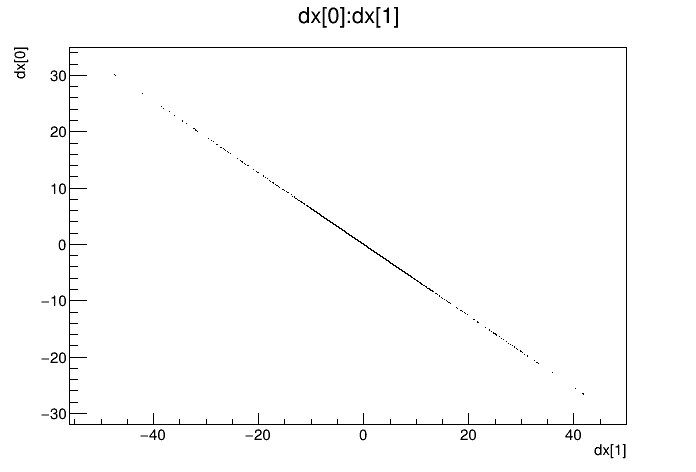

In [9]:
gPad->SetLogy(0);
tree->Draw("dx[0]:dx[1]");
c1->Draw();

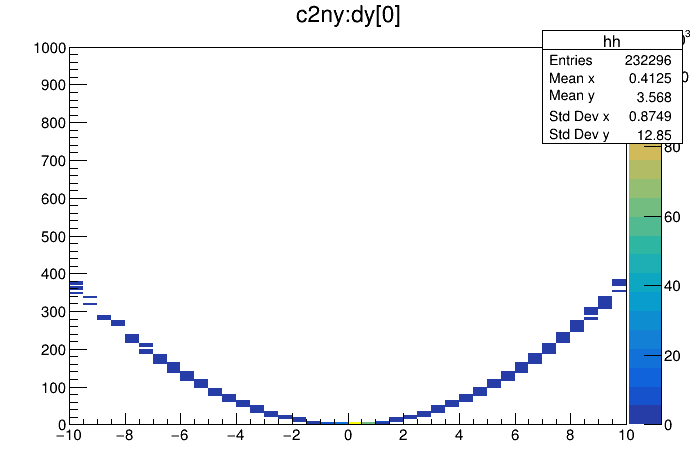

In [10]:
tree->Draw("c2ny:dy[0]>>hh(40,-10,10,200,0,1000)","","colz");
c1->Draw();//从chi2/ndf图上可看出，部分事件的径迹拟合误差很大，这部分要在后续数据处理中去掉。

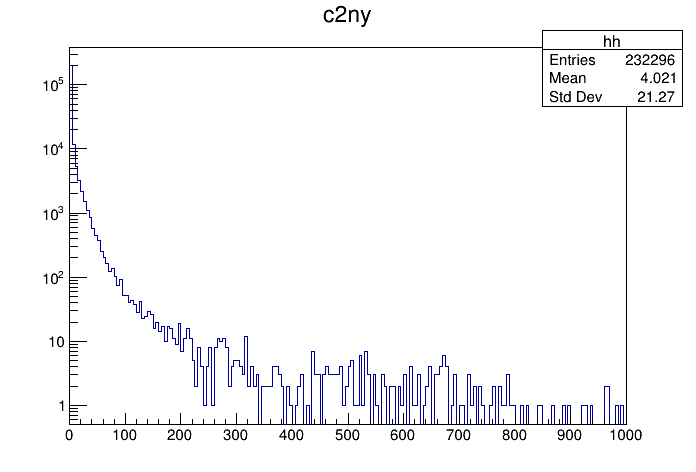

In [11]:
tree->Draw("c2ny>>hh(200,0,1000)","","");
gPad->SetLogy();
c1->Draw();//从chi2/ndf图上可看出，部分事件的径迹拟合误差很大，这部分要在后续数据处理中去掉。

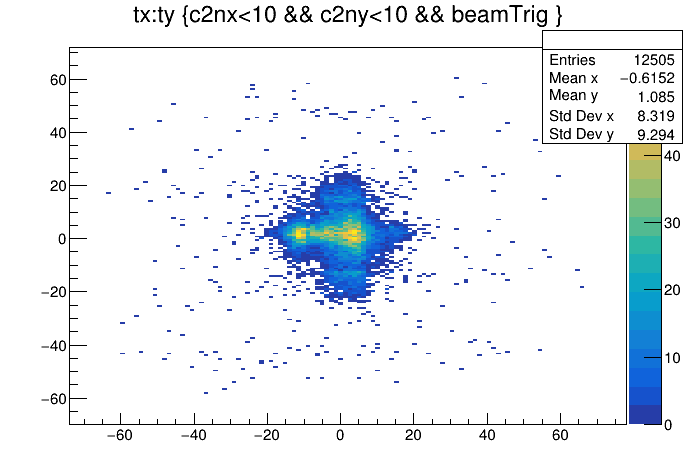

In [12]:
gPad->SetLogy(0);
tree->Draw("tx:ty>>(120,-60,60)","c2nx<10 && c2ny<10 && beamTrig ","colz");
c1->Draw();//

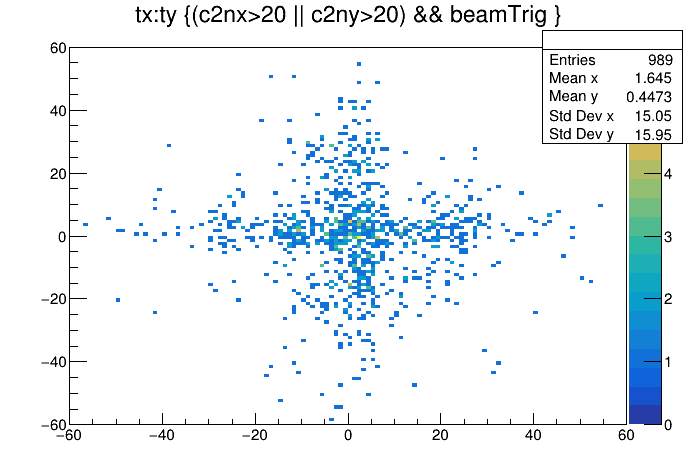

In [13]:
tree->Draw("tx:ty>>(120,-60,60,120,-60,60)","(c2nx>20 || c2ny>20) && beamTrig ","colz");
c1->Draw();//

## PPAC2B x,y,x-y的探测效率

In [14]:
Long64_t N_track;
TCut c2btrack="abs(xx2b[1])<100 && abs(yy2b[1])<100";//拟合径迹穿过探测器的灵敏面积

Long64_t Na_det,Nxa_det, Nya_det,Nxya_det;
TCut c2banode="anode2b>-1000";//阳极有信号
TCut c2bxa="abs(xx2b[0])<100 && anode2b>-1000";//x面有正确信号，即x面和阳极同时有信号
TCut c2bya="abs(yy2b[0])<100 && anode2b>-1000";//y面有正确信号，即y面和阳极同时有信号

### 计算穿过探测器灵敏面积的粒子数目

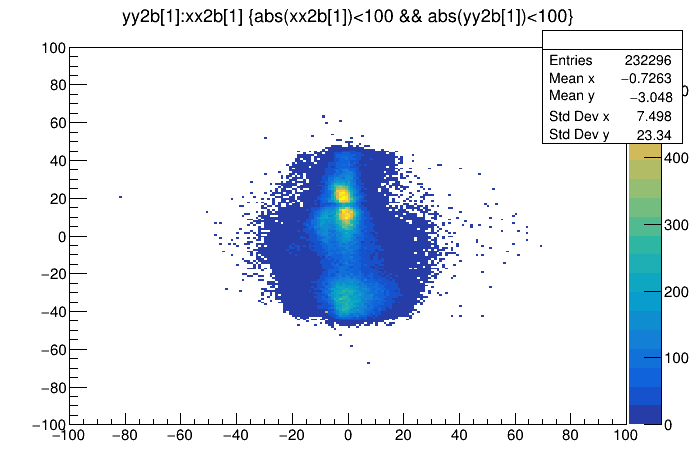

232296


In [15]:
tree->Draw("yy2b[1]:xx2b[1]>>(200,-100,100,200,-100,100)",c2btrack,"colz");//fitted
N_track=tree->GetEntries(c2btrack);//得到给定条件下的计数。
cout<<N_track<<endl;
c1->Draw();

### 计算在上述条件下，探测器的有效信号数目
- 实际气体探测器的效率与束流的种类(A,Z)以及能量有关

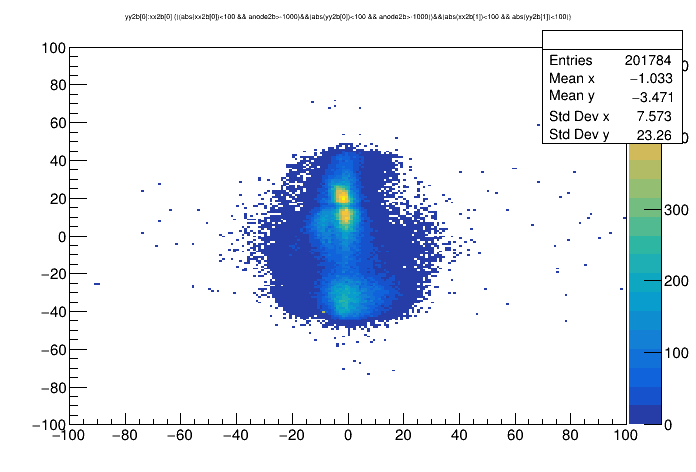

230499 216294 215987 201784


In [16]:
tree->Draw("yy2b[0]:xx2b[0]>>(200,-100,100,200,-100,100)",c2bxa&&c2bya&&c2btrack,"colz");
Na_det=tree->GetEntries(c2banode && c2btrack);//Anode 数目
Nxa_det=tree->GetEntries(c2bxa && c2btrack);// cathod-x 数目
Nya_det=tree->GetEntries(c2bya && c2btrack);// cathod-y 数目
Nxya2_det=tree->GetEntries(c2bxa && c2bya && c2btrack);//cathod-x && cathod-y 数目
cout<<Na_det<<" "<<Nxa_det<<" "<<Nya_det<<" "<<Nxya2_det<<endl;
c1->Draw();

### 计算anode,x, y, x-y 的探测效率

In [17]:
Double_t effa,effxa,effya,effxya2,effxya;

In [18]:
effa=Double_t(Na_det)/N_track;
effxa=Double_t(Nxa_det)/N_track;//ex*ea
effya=Double_t(Nya_det)/N_track;//ey*ea
effxya2=Double_t(Nxya2_det)/N_track;//ex*ey*ea*ea
effxya=Double_t(Nxya2_det)/N_track /effa;

In [19]:
TString eff;
eff.Form("PPAC2B:\n eff_a=%2.f%%,\n eff_xa=%.2f%%, \n eff_ya=%.2f%%",effa*100,effxa*100,effxa*effya*100);
cout<<eff.Data()<<endl;
eff.Form("\n eff_xya2=%.2f%% \n eff_xya=%.2f%%",effxya2*100,effxya*100);
cout<<eff.Data()<<endl;

PPAC2B:
 eff_a=99%,
 eff_xa=93.11%, 
 eff_ya=86.57%

 eff_xya2=86.87% 
 eff_xya=87.54%


In [20]:
!jupyter nbconvert exercise2.2 --to html

[NbConvertApp] Converting notebook exercise2.2.ipynb to html


